Есть таблица с информацией по интернет-магазину, который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
В файле данные до 2016 года. Нужно спланировать кампанию на 2017-й.

# Исследование интернет-магазина

## Шаг 1. Изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


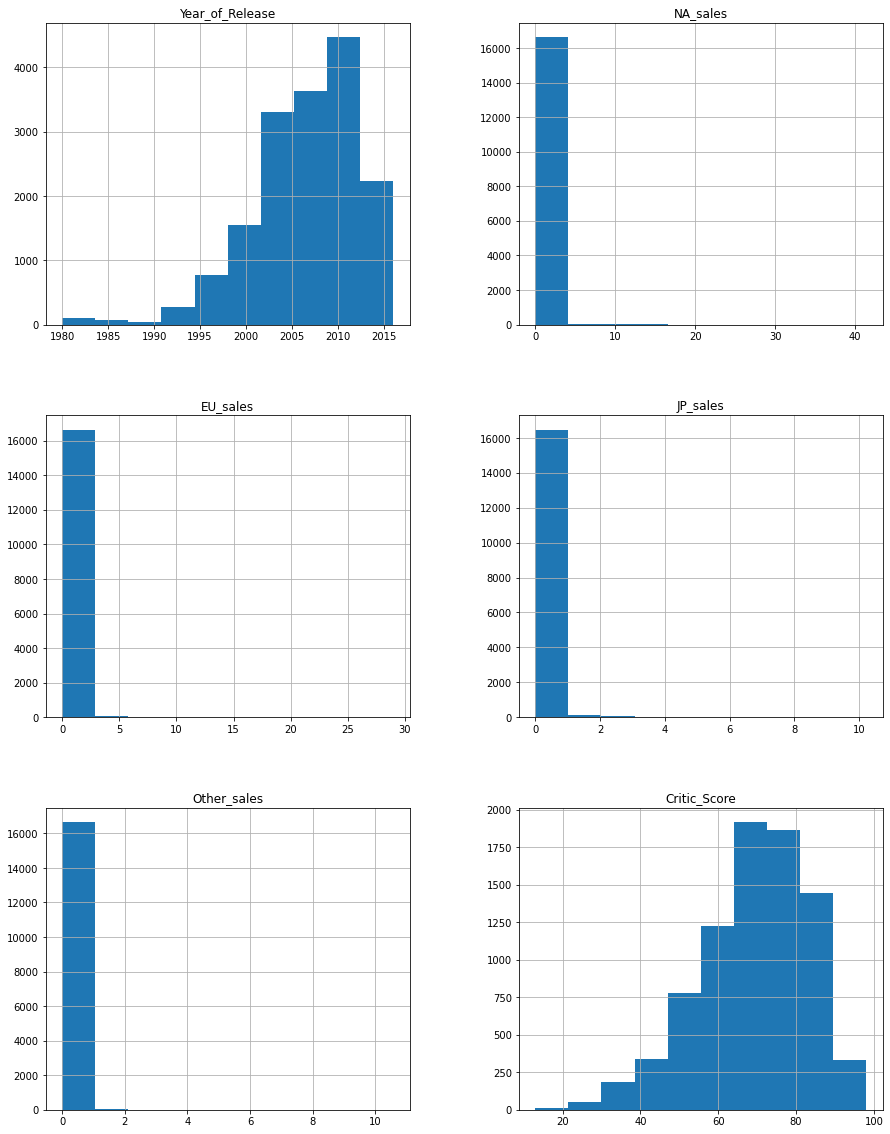

In [4]:
data.hist(figsize=(15, 20));

In [5]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

В некоторых столбцах есть пропуски, которые нужно будет заполнить, также сами названия столбцов некорректны

## Шаг 2. Подготовка данных

### Замена названия столбцов (приведение к нижнему регистру)

In [6]:
data.columns = data.columns.str.lower()

Привели название колонок к "змеиному регистру"

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Преобразование данных


In [8]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
data['user_score'] = data['user_score'].astype('float')

Так как встретилась аббревиатура 'tbd' - будет определено -, невозможно сразу изменить тип, поэтому была обработка такого формата.

In [9]:
data['year_of_release'].describe()

count    16446.000000
mean      2006.484616
std          5.877050
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

In [10]:
data['year_of_release'] = pd.to_numeric(data['year_of_release'], errors='ignore')
data = data.dropna(subset=['year_of_release', 'name', 'genre']).reset_index(drop=True)

В годах есть большая разница между 1980 и 2016, поэтому лучше удалить пропуски. В этих столбцах пропусков не так много, поэтому  от них можно избавиться. Столбец с рейтингом с таким больши пропусков, потому ESRB появилось только в 2005 году, то есть у игр действительно нет возрастного ценза.

In [11]:
data['critic_score'].describe()

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [12]:
data['critic_score'] = pd.to_numeric(data['critic_score'], errors='ignore')
data['critic_score'] = data['critic_score'].fillna(-1)

Здесь также присутствует большой разброс значений, но мнения критиков нельзя предугадать, поэтому заменяем на заглушку

In [13]:
data['user_score'].describe()

count    7463.000000
mean        7.126330
std         1.499447
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

In [14]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='ignore')
data['user_score'] = data['user_score'].fillna(-1)

Для оценок пользователей аналогично

In [15]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,NaN


### Суммарные продажи во всех регионах и преобразуем их в отдельный столбец

In [17]:
data['sum_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,NaN,31.38


Добавили новый столбец с суммой общих продаж

## Шаг 3. Исследовательский анализ данных


### Рассмотрим, сколько игр выпускалось в разные годы
### Важны ли данные за все периоды?
### Рассмотрим, как менялись продажи по платформам. 

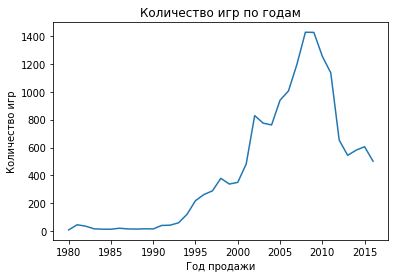

In [18]:
year_count = data.groupby('year_of_release')['name'].count()
year_count.plot();
plt.xlabel('Год продажи')
plt.ylabel('Количество игр')
plt.title('Количество игр по годам')
plt.show()

по графику видно, что пик популярности создания игр был с начала 2000 до 2010 годов, поэтому исследование необходимо проводить с уклоном на эти данные, так как благодаря более широкой выборке они более информативны.

### Платформы с наибольшими суммарными продажами и построение распределение по годам. 


In [19]:
sum_pivot = data.pivot_table(index='platform', values='sum_sales', aggfunc='sum')
sum_pivot.columns = ['sum_sales']
sum_pivot.sort_values(by='sum_sales', ascending=False).head()

,sum_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78


Возьмем первые 5 платформ по количеству продаж для дальнейшего рассмотрения, так как они более репрезентативны.

### За какой характерный срок появляются новые и исчезают старые платформы?


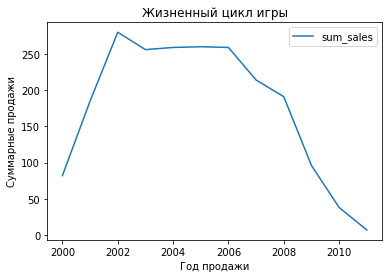

In [20]:
(
    data.query('platform == "PS2"')
    .pivot_table(index='year_of_release', values='sum_sales', aggfunc='count')
    .plot()
)   
plt.xlabel('Год продажи')
plt.ylabel('Суммарные продажи')
plt.title('Жизненный цикл игры')
plt.show()

Основной жизненный цикл платформы - 6 лет, но данные актуальны для 2000, когда потребить был менне требователен.

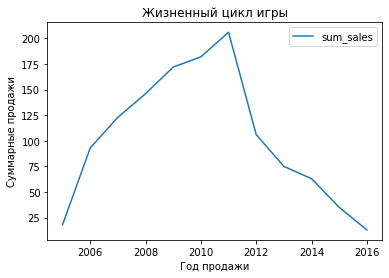

In [21]:
(
    data.query('platform == "X360"')
    .pivot_table(index='year_of_release', values='sum_sales', aggfunc='count')
    .plot()
)   
plt.xlabel('Год продажи')
plt.ylabel('Суммарные продажи')
plt.title('Жизненный цикл игры')
plt.show()

В более поздние года заметно, что основной жизненный цикл - около 4 лет, что меньше, чем в 2000, то есть с течением времени пользователи желают большее количество обновлений

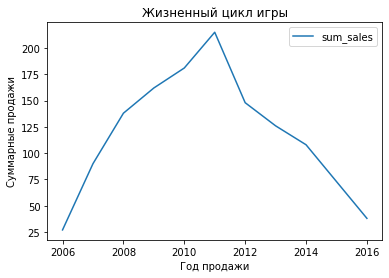

In [22]:
(
    data.query('platform == "PS3"')
    .pivot_table(index='year_of_release', values='sum_sales', aggfunc='count')
    .plot()
)  
plt.xlabel('Год продажи')
plt.ylabel('Суммарные продажи')
plt.title('Жизненный цикл игры')
plt.show()

Так как PS стала классической платформой, известной многим, более новая модель была популярна около 7 лет, при этом пик популярности стал коротким - всего год

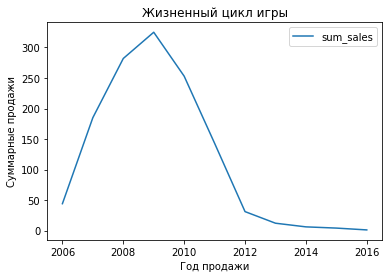

In [23]:
(
    data.query('platform == "Wii"')
    .pivot_table(index='year_of_release', values='sum_sales', aggfunc='count')
    .plot()
);
plt.xlabel('Год продажи')
plt.ylabel('Суммарные продажи')
plt.title('Жизненный цикл игры')
plt.show()

У данной платформы заметен резкий спад популярности, связанный с появлением других, более известных и удачных вариантов. 

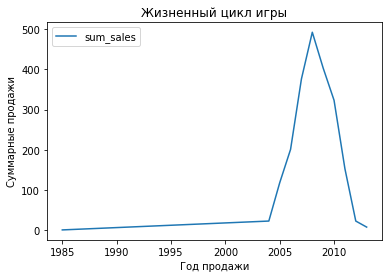

In [24]:
(
    data.query('platform == "DS"')
    .pivot_table(index='year_of_release', values='sum_sales', aggfunc='count')
    .plot()
);
plt.xlabel('Год продажи')
plt.ylabel('Суммарные продажи')
plt.title('Жизненный цикл игры')
plt.show()

Достаточно старая платформа, которая обрела популярность спустя десятилетия после своего выпуска, а ее период популярности при этом составил всего 5-6 лет. Был медленный рост продаж, который увеличился в несколько раз после 2004 года

### Выберем данные за соответствующий актуальный период.

In [25]:
data = data.query('year_of_release > 2013')
data.reset_index(drop=True)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,NaN,14.63
1,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014.0,Role-Playing,4.35,3.49,3.10,0.74,-1.0,-1.0,NaN,11.68
3,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,-1.0,-1.0,NaN,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
1684,Strawberry Nauts,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01
1685,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01
1686,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01
1687,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01


Судя по предыдущим графикам, стало понятно, что средний цикл жизни - около 6 лет, из которых около 4 - популярность, поэтому данные до 2012 года будут неактуальны, берем 2013, чтобы охватить и новые платформы

### Какие платформы лидируют по продажам, растут или падают? 


In [26]:
sum_pivot2 = data.pivot_table(index='platform', values='sum_sales', aggfunc='sum')
sum_pivot2.columns = ['sum_sales']
popular = sum_pivot2.sort_values(by='sum_sales', ascending=False).head()
popular

,sum_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22


Будем делать акцент в исследовании на 5 самых популярных платоформ, так как на их показатели можно ориентироваться.

### График «ящик с усами» по глобальным продажам игр в разбивке по платформам. 


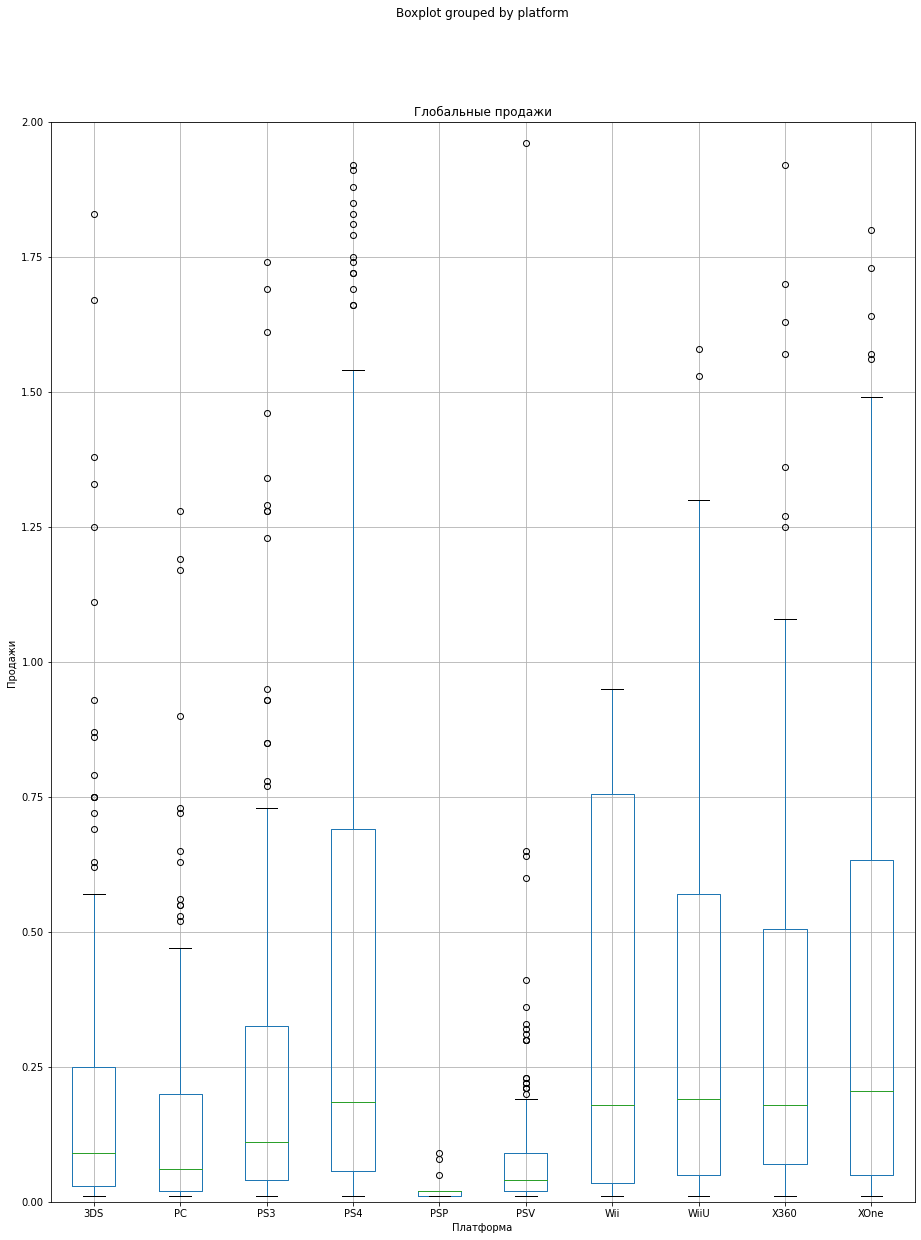

In [27]:
data.boxplot(column='sum_sales', by='platform', figsize=(15,20))
plt.ylim(0,2)
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.title('Глобальные продажи')
plt.show()

Самый большой размах у PS4 и XOne, хотя среднее находится достаточно низко, на одной линии с остальными. Самые низкие показатели у PSP, PSV - размах и сами значения меньше в сравнении с остальными, но есть выбросы.

### Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Диаграмма рассеяния и корреляцию между отзывами и продажами. Сформулируйте выводы.


#### Крреляция для популярной платформы

In [28]:
data2 = data.loc[data['critic_score'] != -1]
data2 = data2.loc[data['user_score'] != -1]

In [29]:
data_corr = data2[['platform','critic_score', 'user_score', 'sum_sales']]

 data2, data_corr для более удобного подсчета

In [30]:
data_corr.query('platform == "PS4"').corr()

,critic_score,user_score,sum_sales
critic_score,1.000000,0.546434,0.401903
user_score,0.546434,1.000000,-0.043186
sum_sales,0.401903,-0.043186,1.000000


По матрице видно, что корреляция отдельных величин есть, далее рассмотрим детально

In [31]:
data2.query('platform == "PS4"')['sum_sales'].corr(data2['critic_score'])

0.40190287811475334

У количества продаж есть зависимость от оценки, то есть люди действительно прислушиваются, но не берут оценку за правило, тк корреляция на среднем уровне

In [32]:
data2.query('platform == "PS4"')['sum_sales'].corr(data2['user_score'])

-0.04318585997193634

Корреляция практически нулевая, также отрицательная (обратаная зависимость), но настолько мала, что ее можно не учитывать

#### Крреляция для непопулярных платформ

In [33]:
data_corr.query('platform != "PS4"').corr()

,critic_score,user_score,sum_sales
critic_score,1.000000,0.485783,0.304789
user_score,0.485783,1.000000,0.043490
sum_sales,0.304789,0.043490,1.000000


По матрице видно, что корреляция на слабом уровне, рассмотрим отдельно по оценкам ниже

In [34]:
data2.query('platform != "PS4"')['sum_sales'].corr(data2['critic_score'])

0.3047894679009596

С остальными платформами корреляция также достаточно низкая, несмотря не то что оценка критиков обычно считается достаточно весомой.

In [35]:
data2.query('platform != "PS4"')['sum_sales'].corr(data2['user_score'])

0.04349004366944432

Здесь так же, как и при корреляции с популярной платформой, сама корреляция близка к нулю, то есть связь низкая

#### Графики оценок для популярной платформы

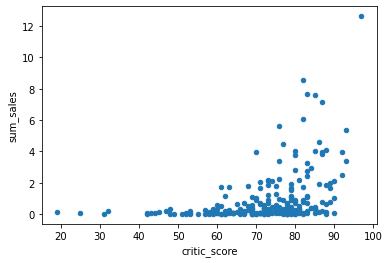

In [36]:
data2.loc[data2['platform'] == 'PS4'].plot(x='critic_score', y='sum_sales', kind='scatter');

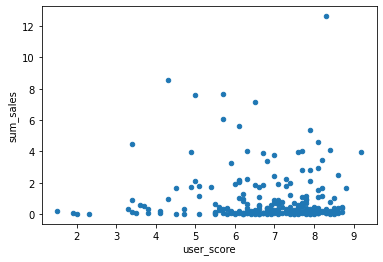

In [37]:
data2.loc[data2['platform'] == 'PS4'].plot(x='user_score', y='sum_sales', kind='scatter');

По графику видно, что в обоих случаях зависимость не наблюдается

#### Графики оценок для непопулярных платформ

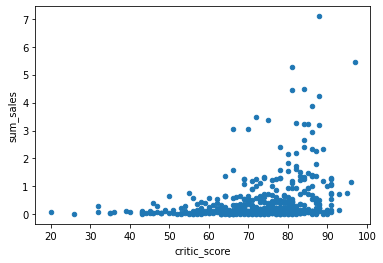

In [38]:
data2.loc[data2['platform'] != 'PS4'].plot(x='critic_score', y='sum_sales', kind='scatter');

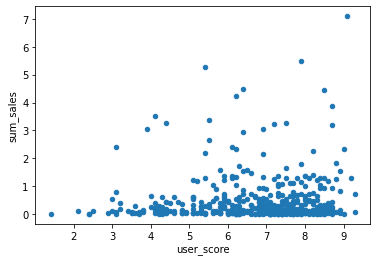

In [39]:
data2.loc[data2['platform'] != 'PS4'].plot(x='user_score', y='sum_sales', kind='scatter');

Для других платформ ситуация не меняется.

### Выводы по сравнению с продажами игр на других платформах.


В сумме самой удачной платформой является PS, любая модель, так как бренд хорошо себя зарекомендовал на рынке, его знают все. Платформа удовлетворяет большую часть потребностей потребителя.

### Общее распределение игр по жанрам: самые прибыльные жанры, выделяются ли жанры с высокими и низкими продажами

In [ ]:
sum_genre = data.pivot_table(index='genre', values='sum_sales', aggfunc=['median', 'mean'])
sum_genre.columns = ['median', 'mean']
sum_genre.sort_values(by='median', ascending=False)

,median,mean
genre,,
Shooter,0.515,1.335469
Sports,0.180,0.680000
Platform,0.140,0.476053
Fighting,0.125,0.470333
Role-Playing,0.110,0.459005
Simulation,0.100,0.298409
Action,0.090,0.322068
Misc,0.090,0.332301
Racing,0.090,0.398841


Общие продажи - плохая метрика для поиска наиболее прибыльного жанра. За высокими показателями общих продаж может скрываться множество мелких игр с низкими продажами. Или 2-3 звезды и куча провалов. Лучше найти жанр, где игры стабильно приносят высокий доход - для этого стоит рассмотреть средние или медианные продажи.

Достаточно четко прослеживаются лидеры, продажи у которых отличаются, также заметны и три жанра в конце списка, показатели которых достаточно малы, что говорит о их невостребованности. Самый прибыльны1 жанр - Shooter, а игры Puzzle, Adventure, Strategy достаочно скучные, поэтому предпочтение отдают первым в списке.

## Шаг 4. Портрет пользователя каждого региона


### Определение для пользователя каждого региона (NA, EU, JP):
#### Самые популярные платформы (топ-5).

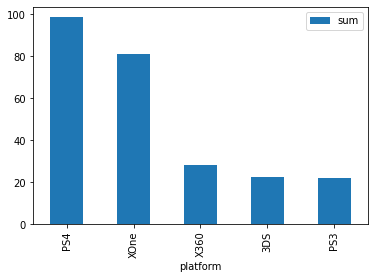

In [41]:
na = data.pivot_table(index='platform', values='na_sales', aggfunc='sum')
na.columns = ['sum']
na.sort_values(by='sum', ascending=False).head().plot(kind='bar');

Первые две позиции в разы отличаются от последних, так как 3DS в принципе не очень популярен, а  PS3 ушла из пользования из-за PS4. Для Америки лидер - PS4 с достаточным отрывом.

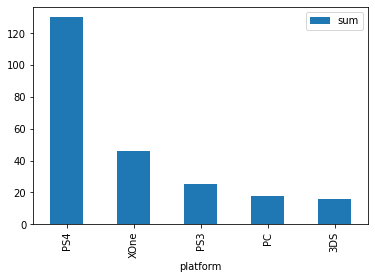

In [42]:
eu = data.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
eu.columns = ['sum']
eu.sort_values(by='sum', ascending=False).head().plot(kind='bar');

В Европе заметно лидирует PS4 - достаточно привычная вещь, которая будет актуально долгое время, остальные же платформы с заметным отрывом уступают первой, так как новая модель заинтеревосвала пользователей в большей степени

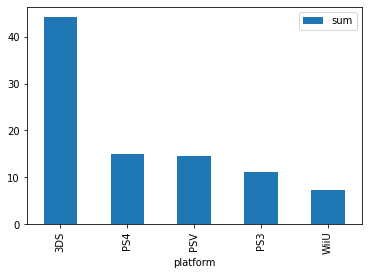

In [43]:
jp = data.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
jp.columns = ['sum']
jp.sort_values(by='sum', ascending=False).head().plot(kind='bar');

3В Японии же не самый известный лидер - 3DS, который в предыдущих странах был на последних позициях. У  3DS заметен сильный отрыв от конкурентов, хотя в целом продажи в Японии на порядок меньше даже в сравнении с Европой.

### Определение для пользователя каждого региона (NA, EU, JP):
#### Самые популярные жанры (топ-5). 

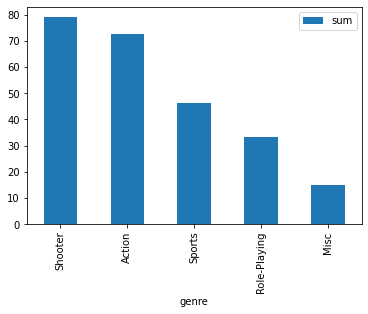

In [44]:
na_genre = data.pivot_table(index='genre', values='na_sales', aggfunc='sum')
na_genre.columns = ['sum']
na_genre.sort_values(by='sum', ascending=False).head().plot(kind='bar');

В Америке популярны активные игры с интересным сюжетом(Shooter, Action), что достаточно понятно для среднего потребителя

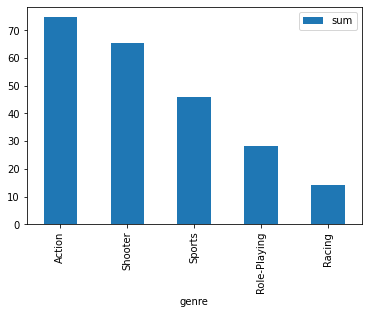

In [45]:
eu_genre = data.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
eu_genre.columns = ['sum']
eu_genre.sort_values(by='sum', ascending=False).head().plot(kind='bar');

В Европе ситуация схожа, так как активные игры (Action, Shooter) актуальны всегда

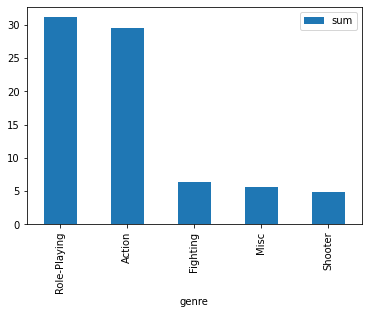

In [46]:
jp_genre = data.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
jp_genre.columns = ['sum']
jp_genre.sort_values(by='sum', ascending=False).head().plot(kind='bar');

Даже отличавшаяся ранее Япония также заинтересована  Action, а не пазлах

### Определение для пользователя каждого региона (NA, EU, JP):
#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

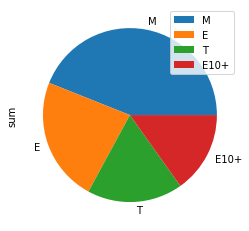

In [47]:
na_rating = data.pivot_table(index='rating', values='na_sales', aggfunc='sum')
na_rating.columns = ['sum']
na_rating.sort_values(by='sum', ascending=False).plot(kind='pie', subplots=True);

В Америке предпочтение отдают играм М и, наоборот, играм для категории Е, так как во взрослых вариантах чаще встречаются интересные сюжеты, что побуждает к покупке, а детские игры востребованы засчет больго количества детей.

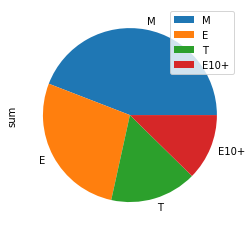

In [48]:
eu_rating = data.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
eu_rating.columns = ['sum']
eu_rating.sort_values(by='sum', ascending=False).plot(kind='pie', subplots=True);

Для Европы ситуация аналогична, так как логика людей для каждой страны примерно одинакова

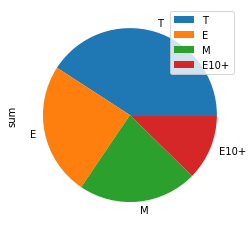

In [49]:
jp_rating = data.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
jp_rating.columns = ['sum']
jp_rating.sort_values(by='sum', ascending=False).plot(kind='pie', subplots=True);

В Японии же все резко меняется, так как страна известа своими строгими законами, из-за которых игры М могут преобрести действительно тек, кто достиг этого возраста, поэтому лидируют по продажам Е и Т, так как основные пользователи игр.

## Проверка гипотез 

### 📊 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Проверка гипотезы: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

```
H_0: Средний пользовательский рейтинг Xbox = средний пользовательский рейтинг РС`
H_a: Средний пользовательский рейтинг Xbox ≠ средний пользовательский рейтинг РС`
alpha = 0.05
```

In [50]:
xone = data2.query('platform == "XOne"')['user_score']
pc = data2.query('platform == "PC"')['user_score']

In [51]:
results = st.ttest_ind(xone, pc, equal_var=False)
alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print(results.pvalue)
    print('Отвергаем нулевую гипотезу ')
else:
    print(results.pvalue)
    print('Не получилось отвергнуть нулевую гипотезу')

0.1403785186826978
0.1403785186826978
Не получилось отвергнуть нулевую гипотезу


Тест для сравнения среднего двух генеральных совокупностей.

### 📊 Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Проверка гипотезы: Средние пользовательские рейтинги жанров Action и Sports разные;

```
H_0: Средний пользовательский рейтинг Action ≠ Средний пользовательский рейтинг Sports`
H_a: Средний пользовательский рейтинг Action = Средний пользовательский рейтинг Sports`
alpha = 0.05
```

In [52]:
action = data2.query('genre == "Action"')['user_score']
sports = data2.query('genre == "Sports"')['user_score']

In [53]:
results = st.stats.ttest_ind(action, sports, equal_var=False)
alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print(results.pvalue)
    print('Отвергаем нулевую гипотезу ')
else:
    print(results.pvalue)
    print('Не получилось отвергнуть нулевую гипотезу')

8.327612976032047e-09
8.327612976032047e-09
Отвергаем нулевую гипотезу 


/tmp/ipykernel_137/4042797306.py:1: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  results = st.stats.ttest_ind(action, sports, equal_var=False)


Опять же сравниваем среднее двух генеральных совокупностей, поэтому данный тест

## Общий вывод 

На начальном этапе были обработаны данные для удобства и большей информативности, также был добавлен новый столбец с общими продажами для рассмотрения данных в полном объеме.

В процессе исследования стало понятно, что не все данные актуальны, так как средний срок жизни платформы - 8 лет, а время популярности - около 6, поэтому были отброшены лишние данные для более точного прогнощирования в дальнейшем.

Также посмотрев на корреляцию продаж и рейтинг, был сделан вывод, что оценки потребителей не играют никакой роли, а оценки критиков незначительно влияют на выбор при покупке.

Портрет пользователя Северной Америки: играет в Shooter категории М на PS4

Портрет пользователя Европы: играет в Action категории М на PS4

Портрет пользователя Японии: играет в  Role-Playing категории T на 3DS

В 4 блоке не удалось отвергнуть гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, но гипотезу о том, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные получилось отвергнуть.